![](https://storage.googleapis.com/kaggle-media/competitions/dsb-2018/dsb.jpg)

In [1]:
!pip install edafa #TTA library

In [2]:
class TTA_ModelWrapper():
    """A simple TTA wrapper for keras computer vision models.

    Args:
        model (keras model): A fitted keras model with a predict method.
    """

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        """Wraps the predict method of the provided model.
        Augments the testdata with horizontal and vertical flips and
        averages the results.

        Args:
            X (numpy array of dim 4): The data to get predictions for.
        """

        pred = []
        for x_i in X:
            p0 = self.model.predict(self._expand(x_i[:, :, 0]))
            p1 = self.model.predict(self._expand(np.fliplr(x_i[:, :, 0])))
            p2 = self.model.predict(self._expand(np.flipud(x_i[:, :, 0])))
            p3 = self.model.predict(self._expand(np.fliplr(np.flipud(x_i[:, :, 0]))))
            p = (p0 +
                 self._expand(np.fliplr(p1[0][:, :, 0])) +
                 self._expand(np.flipud(p2[0][:, :, 0])) +
                 self._expand(np.fliplr(np.flipud(p3[0][:, :, 0])))
                 ) / 4
            pred.append(p)
        return np.array(pred)

    def _expand(self, x):
        return np.expand_dims(np.expand_dims(x, axis=0), axis=3)

# 0. Intro
### Основная идея: Делаем решение на базе U-Net

https://analysiscenter.github.io/radio/index.html RadIO is a framework for data science research of computed tomography (CT) imaging.

In [3]:
#!pip install git+https://github.com/analysiscenter/radio.git

In [4]:
import os
import sys
import glob
import random
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import skimage.io                           #Used for imshow function
import skimage.transform                    #Used for resize function
from skimage.morphology import label        #Used for Run-Length-Encoding RLE to create final submission
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Lambda, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, Adamax, Adadelta
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
#import radio
from edafa import SegPredictor

from skimage.filters import unsharp_mask

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) 
Numpy        : 1.19.5
Skimage      : 0.18.1
Keras        : 2.4.3
Tensorflow   : 2.4.0


In [5]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [6]:
# seed values
SEED = 42
random.seed = SEED
np.random.seed(seed=SEED)

# SETUP

In [7]:
def plot_loss_history(history):
    # validation losses
    val_loss = history.history['val_loss']
    loss = history.history['loss']

    plt.title('Loss')
    plt.plot(val_loss, 'r', loss, 'b')
    plt.show()
    

In [8]:
# SETUP
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'

IMG_WIDTH       = 256
IMG_HEIGHT      = 256
IMG_CHANNELS    = 3

BATCH_SIZE      = 32#32#32
NUM_EPOCHS      = 75
# STEPS_PER_EPOCH = 600
LR              = 0.001 #0.001
validation_split= 0.1

# 1. Load Data
распаковываем данные

In [9]:
# распаковываем данные
import zipfile

for name_data in ['test', 'train']:
    tmp_zip = zipfile.ZipFile('../input/sf-dl-nucleus-detection//'+name_data+'.zip')
    tmp_zip.extractall(name_data)
    tmp_zip.close()

Для начала глянем csv

In [10]:
sample_submission = pd.read_csv('../input/sf-dl-nucleus-detection/sample_submission.csv')
sample_submission.sample(5)

,ImageId,EncodedPixels
53,d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0...,1 1
60,eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9...,1 1
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,1 1
45,a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a26...,1 1
5,0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c0...,1 1


In [11]:
len(sample_submission)

65

Не кажеться странным, что нам предлагают на тест только 65 уникальных картинок? )  
посмотрим что в трейне...

In [12]:
train_labels = pd.read_csv('../input/sf-dl-nucleus-detection/train_labels.csv')
train_labels.sample(10)

,ImageId,EncodedPixels
16141,8b77284d6f37ab3fc826139ebadaec3b9d81c552fe525c...,55530 7 55784 12 56039 14 56294 16 56549 18 56...
27194,ea94ba4b01d1bd5f7768d10e0ac547743791033df545c7...,12295 8 12550 11 12805 14 13060 17 13316 18 13...
24216,cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9...,37435 5 37690 7 37945 8 38201 8 38457 8 38713 ...
25304,da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e751...,18647 6 19166 8 19686 9 20206 9 20726 8 21247 ...
21273,b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d4...,331026 5 331543 9 332062 12 332580 15 333099 1...
9796,538b7673d507014d83af238876e03617396b70fe27f525...,127462 4 128064 8 128666 12 129268 16 129870 2...
3410,1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526...,431986 4 433009 5 434033 5 435057 6 436081 6 4...
16126,8aa1a883f61f0bb5af3d3d60acaaf33af45ef4fbffaac1...,59092 3 59345 8 59600 11 59856 11 60112 11 603...
9577,4e23ecf65040f86420e0201134e538951acdeda84fbb27...,55041 2 55297 4 55553 5 55809 6 56065 6 56321 ...
27756,ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5...,23588 3 23843 5 24099 5 24355 5 24612 3


In [13]:
len(train_labels)

29461

в описании датасета написано что "Каждая маска содержит одно ядро."  
А из всех 29к примеров, сколько у нас уникальных изображений для тренировки на самом деле?

In [14]:
len(train_labels) - train_labels.ImageId.duplicated().sum()

670

Сверяем по папкам

In [15]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))
test_ids = next(os.walk(TEST_PATH))

mask_count = 0
for train_id in train_ids[1]:
    masks = next(os.walk(TRAIN_PATH + train_id + '/masks/'))[2]
    mask_count += len(masks)

print('There are {} images.'.format(len(train_ids[1])))
print('There are {} masks.'.format(mask_count))
print('Approximately {} masks per image.'.format(mask_count // len(train_ids[1])))

There are 670 images.
There are 29461 masks.
Approximately 43 masks per image.


Вот все и встало на свои места, Итого 65 изображений на тесте и 670 на трейне.  
Давай подгрузим и посмотрим эти картинки

In [16]:
def ADJ_IMG_1_(img):

    #return img
    selem = skimage.morphology.square(5)
    
    img = skimage.filters.gaussian(img/255, sigma=(1, 1), truncate=1, multichannel=True) 
    img_hsv = skimage.color.rgb2hsv(img)

#     img_hsv[0] = skimage.morphology.area_closing(img_hsv[0], area_threshold=20, connectivity=1)
#     img_hsv[1] = skimage.morphology.area_closing(img_hsv[1], area_threshold=20, connectivity=1)
#     img_hsv[2] = skimage.morphology.area_closing(img_hsv[2], area_threshold=20, connectivity=1)

#     img_hsv[0] = skimage.morphology.closing(img_hsv[0], selem)
#     img_hsv[1] = skimage.morphology.closing(img_hsv[1], selem)
    img_hsv[2] = skimage.morphology.closing(img_hsv[2], selem)
    
    
#     img_hsv[2] = unsharp_mask(
#                          img_hsv[2],
#                          radius=5,
#                          amount=7
#                      )
#     img_hsv[0] = skimage.morphology.erosion(img_hsv[0], selem)
#     img_hsv[1] = skimage.morphology.erosion(img_hsv[1], selem)
    img_hsv[2] = skimage.morphology.erosion(img_hsv[2], selem)
    
    img = skimage.color.hsv2rgb(img_hsv)
    img = skimage.exposure.equalize_adapthist(img, clip_limit=0.01)
    
    img_hsv = skimage.color.rgb2hsv(img)
    thresh = skimage.filters.threshold_otsu(img_hsv[2])
    img_hsv[2] = img_hsv[2] > thresh
    img = skimage.color.hsv2rgb(img_hsv)
    #img = skimage.morphology.area_closing(img, area_threshold=20, connectivity=1)
    img = skimage.filters.gaussian(img, sigma=(1, 1), truncate=1, multichannel=True) 
#     skimage.io.imshow(img)
#     plt.show()
    
    img *=255
    img = img.astype(int)
    return img

In [17]:
def ADJ_IMG_2(img):

    #return img
    selem = skimage.morphology.square(5)
    
    img = skimage.filters.gaussian(img/255, sigma=(1, 1), truncate=1, multichannel=True) 
    img_hsv = skimage.color.rgb2hsv(img)

#     img_hsv[0] = skimage.morphology.area_closing(img_hsv[0], area_threshold=20, connectivity=1)
#     img_hsv[1] = skimage.morphology.area_closing(img_hsv[1], area_threshold=20, connectivity=1)
#     img_hsv[2] = skimage.morphology.area_closing(img_hsv[2], area_threshold=20, connectivity=1)

#     img_hsv[0] = skimage.morphology.closing(img_hsv[0], selem)
#     img_hsv[1] = skimage.morphology.closing(img_hsv[1], selem)

# img_hsv[2] = skimage.morphology.closing(img_hsv[2], selem)
    
    
#     img_hsv[2] = unsharp_mask(
#                          img_hsv[2],
#                          radius=5,
#                          amount=7
#                      )
#     img_hsv[0] = skimage.morphology.erosion(img_hsv[0], selem)
#     img_hsv[1] = skimage.morphology.erosion(img_hsv[1], selem)
    img_hsv[2] = skimage.morphology.erosion(img_hsv[2], selem)
    
    img = skimage.color.hsv2rgb(img_hsv)
    img = skimage.exposure.equalize_adapthist(img, clip_limit=0.01)
    
#     thresh = skimage.filters.threshold_otsu(img)
#     img = img > thresh

    #img = skimage.morphology.area_closing(img, area_threshold=20, connectivity=1)
#     img = skimage.filters.gaussian(img, sigma=(1, 1), truncate=1, multichannel=True) 
#     skimage.io.imshow(img)
#     plt.show()
    
    img *=255
    img = img.astype(int)
    return img

In [18]:
def ADJ_IMG_11(img):

    selem = skimage.morphology.square(5)
    selem1 = skimage.morphology.square(2)
    img = skimage.exposure.equalize_adapthist(img/255.0, clip_limit=0.01)
    
    img_hsv = skimage.color.rgb2hsv(img)
    
    img_hsv[2] = unsharp_mask(img_hsv[2], radius=3, amount=7)

    
    thresh = skimage.filters.threshold_otsu(img_hsv[2])
    img_hsv[2] = img_hsv[2] > thresh
    
    img_hsv[2] = skimage.morphology.erosion(img_hsv[2], selem1)
    img_hsv[2] = skimage.morphology.opening(img_hsv[2], selem1)
    
    img = skimage.color.hsv2rgb(img_hsv)


    
    #img = skimage.filters.gaussian(img, sigma=(2, 2), truncate=0.1, multichannel=True) 
#     skimage.io.imshow(img)
#     plt.show()
    
    img *=255
    img = img.astype(int)
    return img

In [19]:
def ADJ_IMG_1_ok(img):
    
    img = skimage.exposure.equalize_adapthist(img/255.0, clip_limit=0.01)
    
    img_hsv = skimage.color.rgb2hsv(img)
    
    #img_hsv[2] = unsharp_mask(img_hsv[2], radius=5, amount=3)
    img_hsv[2] = unsharp_mask(img_hsv[2], radius=7, amount=3)
    #img_hsv[2] = unsharp_mask(img_hsv[2], radius=3, amount=3)
    img = skimage.color.hsv2rgb(img_hsv)
    
    img *=255
    img = img.astype(int)
    return img

In [20]:
def ADJ_IMG_1(img):

    selem = skimage.morphology.square(5)
    
    img = skimage.exposure.equalize_adapthist(img/255.0, clip_limit=0.01)
    img_hsv = skimage.color.rgb2hsv(img)

    
    #img_hsv[2] = unsharp_mask(img_hsv[2], radius=5, amount=3)
    img_hsv[2] = unsharp_mask(img_hsv[2], radius=9, amount=4)
    img_hsv[2] = unsharp_mask(img_hsv[2], radius=17, amount=5)
    #img_hsv[2] = unsharp_mask(img_hsv[2], radius=3, amount=3)
    img_hsv[2] = skimage.morphology.opening(img_hsv[2], selem)
    img_hsv[2] = skimage.morphology.closing(img_hsv[2], selem)
    img = skimage.color.hsv2rgb(img_hsv)
    
    img *=255
    img = img.astype(int)
    return img

In [21]:
def ADJ_IMG_1_(img):
    #return img
    img = skimage.exposure.equalize_adapthist(img/255, clip_limit=0.01)*255
    img = img.astype(int)
    return img

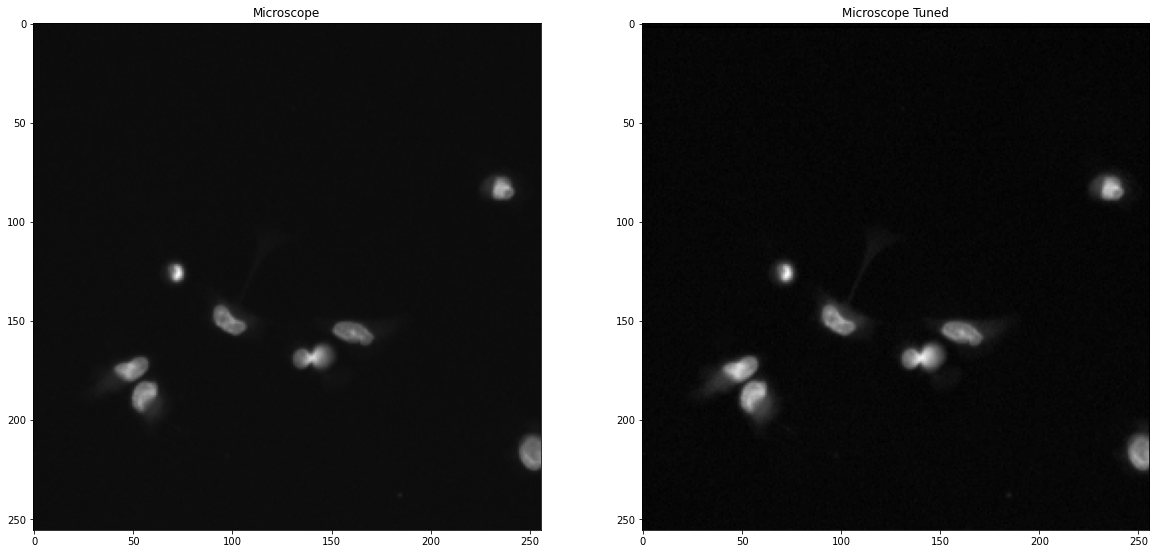

In [22]:
from os import walk
file_list =[]
for path, subdirs, files in os.walk('./test'):
    for name in files:
        file_list.append(os.path.join(path, name))
        
# Check predict data
f, axarr = plt.subplots(1,2)
f.set_size_inches(20,10)
ix = random.randint(0, len(file_list))

im = skimage.io.imread(file_list[ix])[:,:,:3]
im =skimage.transform.resize(im, output_shape=(IMG_WIDTH,IMG_HEIGHT), 
                                                mode='constant', 
                                                preserve_range=True)

imC =skimage.transform.resize(ADJ_IMG_1(im), output_shape=(IMG_WIDTH,IMG_HEIGHT), 
                                                mode='constant', 
                                                preserve_range=True)
im/=255
imC/=255
# skimage.io.imshow(im)
# plt.show()
# skimage.io.imshow(imC)
# plt.show()

axarr[0].imshow(im)
axarr[0].set_title('Microscope')

axarr[1].imshow(imC)
axarr[1].set_title('Microscope Tuned')



plt.show()


# f, axarr = plt.subplots(2,3)
# f.set_size_inches(20,10)
# ix = random.randint(0, len(train_ids[1]))
# axarr[0,0].imshow(X_train[ix])
# axarr[0,0].set_title('Microscope')
# axarr[0,1].imshow(np.squeeze(Y_predict[ix]))
# axarr[0,1].set_title('"Predicted" Masks')
# axarr[0,2].imshow(np.squeeze(Y_train[ix]))
#axarr[0,2].set_title('"GroundTruth" Masks')

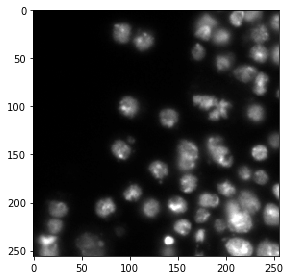

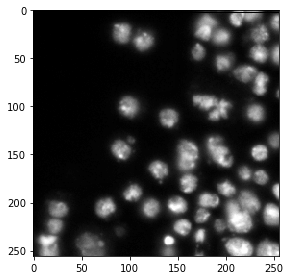

In [23]:
im = skimage.io.imread('./test/697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808/images/697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808.png')[:,:,:3]
im =skimage.transform.resize(im, output_shape=(IMG_WIDTH,IMG_HEIGHT), 
                                                mode='constant', 
                                                preserve_range=True)

imC =skimage.transform.resize(ADJ_IMG_1(im), output_shape=(IMG_WIDTH,IMG_HEIGHT), 
                                                mode='constant', 
                                                preserve_range=True)
im/=255
imC/=255
skimage.io.imshow(im)
plt.show()
skimage.io.imshow(imC)
plt.show()

In [24]:
# для подгрузки данных будем использовать удобную либу skimage
def get_X_data(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    img_paths = ['{0}/{1}/images/{1}.png'.format(path, id) for id in os.listdir(path)]
    X_data = np.array([skimage.transform.resize(ADJ_IMG_1(skimage.io.imread(path)[:,:,:3]), 
                                                output_shape=output_shape, 
                                                mode='constant', 
                                                preserve_range=True) for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands
    
    return X_data

In [25]:
%%time
# Get training data
X_train = get_X_data(TRAIN_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))


CPU times: user 1min 42s, sys: 4.29 s, total: 1min 47s
Wall time: 1min 47s


In [26]:
def get_Y_data(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    img_paths = [glob.glob('{0}/{1}/masks/*.png'.format(path, id)) for id in os.listdir(path)]
    
    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)
    Y_data = np.array(Y_data, dtype=np.bool)
    
    return Y_data

In [27]:
%%time
# Get training data labels
Y_train = get_Y_data(TRAIN_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))
print(Y_train.shape, Y_train.dtype)

(670, 256, 256, 1) bool
CPU times: user 40.6 s, sys: 709 ms, total: 41.3 s
Wall time: 41.3 s


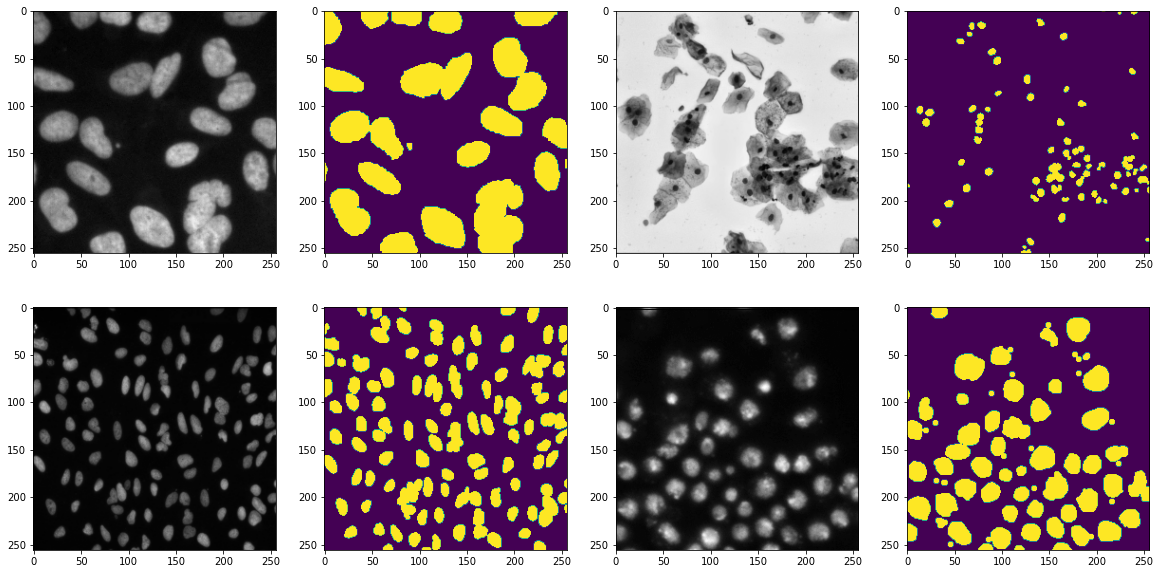

In [28]:
# Check training data
f, axarr = plt.subplots(2,4)
f.set_size_inches(20,10)
ix = random.randint(0, len(train_ids[1]))
axarr[0,0].imshow(X_train[ix])
axarr[0,1].imshow(np.squeeze(Y_train[ix]))

ix1 = random.randint(0, len(train_ids[1]))
axarr[0,2].imshow(X_train[ix1])
axarr[0,3].imshow(np.squeeze(Y_train[ix1]))

ix2 = random.randint(0, len(train_ids[1]))
axarr[1,0].imshow(X_train[ix2])
axarr[1,1].imshow(np.squeeze(Y_train[ix2]))

ix3 = random.randint(0, len(train_ids[1]))
axarr[1,2].imshow(X_train[ix3])
axarr[1,3].imshow(np.squeeze(Y_train[ix3]))

plt.show()

# 2. Build model

> Построим U-Net model, по мотивам [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) и близко к этому [репозиторию](https://github.com/jocicmarko/ultrasound-nerve-segmentation) из Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [29]:
def get_train_test_augmented(X_data=X_train, Y_data=Y_train, validation_split=0.25, batch_size=32, seed=SEED):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                        Y_data,
                                                        train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed)
    
    # Image data generator distortion options
    data_gen_args = dict(

                         rotation_range=45.,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True, #
                         vertical_flip=True, #
                          fill_mode='wrap'
                            )  #use 'constant'??reflect


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
     
    
    # Test data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_test, augment=True, seed=seed)
    Y_datagen_val.fit(Y_test, augment=True, seed=seed)
    X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=True, seed=seed)
    Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=True, seed=seed)
    
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    test_generator = zip(X_test_augmented, Y_test_augmented)
    
    return train_generator, test_generator

In [30]:
from keras import backend as K

def iou_core(y_true, y_pred, smooth=1e-6):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    truepos = K.sum(y_true * y_pred)
    falsepos = K.sum(y_pred) - truepos
    falseneg = K.sum(y_true) - truepos
    iou = (truepos + smooth) / (smooth + truepos + falseneg + falsepos)
    return iou
    

def iou_coef_(y_true, y_pred, smooth=1):

    intersection1 = K.sum(K.abs(y_true * y_pred), axis=-1)
    print(intersection1)
    union = K.sum((y_true,-1) + K.sum(y_pred,-1) - intersection1)
    return((intersection1 + smooth) / ( union + smooth))

def iou_coef(result1, result2):
    intersection = np.logical_and(result1, result2)
    union = np.logical_or(result1, result2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def iou_coef_loss_old(y_true, y_pred):
    y_true = tf.dtypes.cast(y_true, tf.float32)
    print(y_true)
    print('!!-------------------------------------------------------')
    print(y_pred)
    return(-iou_coef_(y_true, y_pred))

def iou_coef_loss(y_true, y_pred):
    smooth = 1
    y_true = tf.dtypes.cast(y_true, tf.float32)
    print('y_true ',y_true)

    print('y_pred ',y_true )
    
    intersection1 = K.sum(K.abs(y_true * y_pred), axis=-1)
    print('intersection1 ', intersection1)
    #union = K.sum((y_true,-1) + K.sum(y_pred,-1) - intersection1)
    union = K.sum(y_true + y_pred - intersection1)
    print('union ', union)
    res = -(intersection1 + smooth) / ( union + smooth)
    print('res ',res)
    return(res)
           
    return(-iou_coef_(y_true, y_pred))

# Функция, которая смотрит на пересечение областей. Нужна для accuracy
def dice_coef(y_true, y_pred, smooth=1e-6):
    #return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    answer = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return answer


def dice_loss(y_true, y_pred):
    y_true = tf.dtypes.cast(y_true, tf.float32)
    return 1-(2. * K.sum(y_true * y_pred) + 0.1) / (K.sum(y_true) + K.sum(y_pred) + 0.1 )

def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def iou_loss_core_M(true,pred):  #this can be used as a loss if you make it negative
    true = tf.dtypes.cast(true, tf.float32)
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    #return 1-( (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon()))
    return 1-( K.sum(intersection, axis=-1 ) / K.sum(union, axis=-1) )

def iou_loss_core_M1(targets,inputs, smooth=1e-6):  #this can be used as a loss if you make it negative
    targets = tf.dtypes.cast(targets, tf.float32)
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(K.dot(targets, inputs))
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return 1 - IoU

def competitionMetric2(true, pred): #any shape can go - can't be a loss function

    tresholds = [0.5 + (i*.05)  for i in range(10)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [31]:
#https://ilmonteux.github.io/2019/05/10/segmentation-metrics.html
def jaccard_coef_logloss(y_true, y_pred, smooth=1e-10):
    """ Loss function based on jaccard coefficient.
    Parameters
    ----------
    y_true : keras tensor
        tensor containing target mask.
    y_pred : keras tensor
        tensor containing predicted mask.
    smooth : float
        small real value used for avoiding division by zero error.
    Returns
    -------
    keras tensor
        tensor containing negative logarithm of jaccard coefficient.
    """
    y_true = tf.dtypes.cast(y_true, tf.float32)
    
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    truepos = K.sum(y_true * y_pred)
    falsepos = K.sum(y_pred) - truepos
    falseneg = K.sum(y_true) - truepos
    jaccard = (truepos + smooth) / (smooth + truepos + falseneg + falsepos)
    return -K.log(jaccard + smooth)

def dice_loss_new(y_true, y_pred, smooth=1e-6):
    """ Loss function base on dice coefficient.

    Parameters
    ----------
    y_true : keras tensor
        tensor containing target mask.
    y_pred : keras tensor
        tensor containing predicted mask.
    smooth : float
        small real value used for avoiding division by zero error.

    Returns
    -------
    keras tensor
        tensor containing dice loss.
    """
    y_true = tf.dtypes.cast(y_true, tf.float32)
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    answer = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1-answer

# Define IoU metric
def mean_iou1(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
#         y_pred_ = tf.to_int32(y_pred > t)
        y_pred_ = tf.dtypes.cast(y_pred > t, tf.int32)
        #score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2)
        score = K.flatten(score)
        up_opt = K.flatten(up_opt)
        #tf.compat.v1.keras.backend.get_session.run(tf.local_variables_initializer())
        #with tf.control_dependencies([up_opt]):
        #score = tf.identity(score)
        prec.append(score)
        prec1 = tf.convert_to_tensor(prec, dtype=tf.float32)
    return K.mean(K.stack(prec1), axis=0)

In [32]:
# Build U-Net model

steps_per_epoch=np.floor(len(X_train)/(BATCH_SIZE)).astype(int)
print(f'steps_per_epoch {steps_per_epoch}')
boundaries = [60*steps_per_epoch, 100*steps_per_epoch]

values = [ LR, LR/2, LR/10]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)


inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='selu', kernel_initializer='lecun_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='selu', kernel_initializer='lecun_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='selu', kernel_initializer='lecun_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='selu', kernel_initializer='lecun_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='selu', kernel_initializer='lecun_normal', padding='same') (p2)
c3 = BatchNormalization() (c3) ##############
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='selu', kernel_initializer='lecun_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='selu', kernel_initializer='lecun_normal', padding='same') (p3)
c4 = BatchNormalization() (c4) ##############
c4 = Dropout(0.3) (c4) #c4 = Dropout(0.3) (c4)
c4 = Conv2D(128, (3, 3), activation='selu', kernel_initializer='lecun_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='selu', kernel_initializer='lecun_normal', padding='same') (p4)
c5 = BatchNormalization() (c5) ##############
c5 = Dropout(0.3) (c5) #c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='selu', kernel_initializer='lecun_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='selu', kernel_initializer='lecun_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='selu', kernel_initializer='lecun_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='selu', kernel_initializer='lecun_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='selu', kernel_initializer='lecun_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='selu', kernel_initializer='lecun_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='selu', kernel_initializer='lecun_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='selu', kernel_initializer='lecun_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='selu', kernel_initializer='lecun_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
optimizer = Adam(lr=LR,) # Adadelta  Adamax
#optimizer = Adam(learning_rate=learning_rate_fn)



#model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=[dice_coef, iou_core])
#!!model.compile(optimizer=optimizer, loss=dice_loss,metrics=[dice_coef, iou_core])
#!!!model.compile(optimizer=optimizer, loss=jaccard_coef_logloss,metrics=[dice_coef, iou_core])
#model.compile(optimizer=optimizer, loss=jaccard_coef_logloss, metrics=[dice_coef, iou_core,tf.keras.metrics.MeanIoU(num_classes=2, name = 'MeanIoU') ])
model.compile(optimizer=optimizer, loss=dice_loss_new, metrics=[dice_coef, tf.keras.metrics.MeanIoU(num_classes=2, name = 'MeanIoU') ])#dice_loss
#dice_loss_new
#model.compile(optimizer=optimizer, loss=tfa.losses.GIoULoss(),metrics=[dice_coef, iou_core])
#model.summary()

steps_per_epoch 20


In [134]:
# Finally train the model step 0!!


validationSplit = 0.10


train_generator, test_generator = get_train_test_augmented(X_data=X_train, Y_data=Y_train, validation_split=validationSplit, batch_size=BATCH_SIZE)

earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint('keras_unet-0.h5', verbose=1, save_best_only=True)


history = model.fit(train_generator, validation_data=test_generator, validation_steps=BATCH_SIZE/2, steps_per_epoch=len(X_train)/(BATCH_SIZE*2), epochs=NUM_EPOCHS, callbacks=[earlystopper, checkpointer])


Epoch 1/75
10/10 [==============================] - 10s 816ms/step - loss: 0.5889 - dice_coef: 0.4111 - MeanIoU: 0.4240 - val_loss: 0.5354 - val_dice_coef: 0.4576 - val_MeanIoU: 0.4108

Epoch 00001: val_loss improved from inf to 0.53539, saving model to keras_unet-0.h5
Epoch 2/75
10/10 [==============================] - 7s 702ms/step - loss: 0.4456 - dice_coef: 0.5543 - MeanIoU: 0.4362 - val_loss: 0.4945 - val_dice_coef: 0.5116 - val_MeanIoU: 0.4013

Epoch 00002: val_loss improved from 0.53539 to 0.49453, saving model to keras_unet-0.h5
Epoch 3/75
10/10 [==============================] - 7s 727ms/step - loss: 0.4408 - dice_coef: 0.5592 - MeanIoU: 0.4383 - val_loss: 0.5137 - val_dice_coef: 0.4608 - val_MeanIoU: 0.4137

Epoch 00003: val_loss did not improve from 0.49453
Epoch 4/75
10/10 [==============================] - 7s 682ms/step - loss: 0.4611 - dice_coef: 0.5368 - MeanIoU: 0.4491 - val_loss: 0.3777 - val_dice_coef: 0.6106 - val_MeanIoU: 0.3941

Epoch 00004: val_loss improved from 

10/10 [==============================] - 7s 768ms/step - loss: 0.3019 - dice_coef: 0.6983 - MeanIoU: 0.7263 - val_loss: 0.1386 - val_dice_coef: 0.8527 - val_MeanIoU: 0.8172

Epoch 00033: val_loss improved from 0.14492 to 0.13859, saving model to keras_unet-0.h5
Epoch 34/75
10/10 [==============================] - 7s 696ms/step - loss: 0.2615 - dice_coef: 0.7385 - MeanIoU: 0.7400 - val_loss: 0.1369 - val_dice_coef: 0.8719 - val_MeanIoU: 0.8291

Epoch 00034: val_loss improved from 0.13859 to 0.13687, saving model to keras_unet-0.h5
Epoch 35/75
10/10 [==============================] - 7s 674ms/step - loss: 0.2512 - dice_coef: 0.7493 - MeanIoU: 0.7650 - val_loss: 0.1422 - val_dice_coef: 0.8259 - val_MeanIoU: 0.8203

Epoch 00035: val_loss did not improve from 0.13687
Epoch 36/75
10/10 [==============================] - 7s 717ms/step - loss: 0.2907 - dice_coef: 0.7093 - MeanIoU: 0.7395 - val_loss: 0.1357 - val_dice_coef: 0.8630 - val_MeanIoU: 0.8121

Epoch 00036: val_loss improved from 0.136

10/10 [==============================] - 7s 698ms/step - loss: 0.2307 - dice_coef: 0.7693 - MeanIoU: 0.7664 - val_loss: 0.1099 - val_dice_coef: 0.9000 - val_MeanIoU: 0.8525

Epoch 00065: val_loss did not improve from 0.10966
Epoch 66/75
10/10 [==============================] - 8s 783ms/step - loss: 0.2288 - dice_coef: 0.7714 - MeanIoU: 0.7819 - val_loss: 0.1128 - val_dice_coef: 0.8878 - val_MeanIoU: 0.8510

Epoch 00066: val_loss did not improve from 0.10966
Epoch 67/75
10/10 [==============================] - 7s 732ms/step - loss: 0.2675 - dice_coef: 0.7325 - MeanIoU: 0.7362 - val_loss: 0.1121 - val_dice_coef: 0.8917 - val_MeanIoU: 0.8479

Epoch 00067: val_loss did not improve from 0.10966
Epoch 68/75
10/10 [==============================] - 7s 678ms/step - loss: 0.2394 - dice_coef: 0.7620 - MeanIoU: 0.7763 - val_loss: 0.1150 - val_dice_coef: 0.8823 - val_MeanIoU: 0.8436

Epoch 00068: val_loss did not improve from 0.10966
Epoch 69/75
10/10 [==============================] - 7s 723ms/st

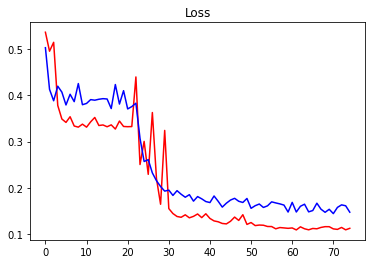

In [135]:

plot_loss_history(history)

Epoch 1/50
19/19 - 5s - loss: 0.0968 - dice_coef: 0.9033 - MeanIoU: 0.8644 - val_loss: 0.0954 - val_dice_coef: 0.9117 - val_MeanIoU: 0.8736

Epoch 00001: val_loss improved from inf to 0.09540, saving model to keras_unet-1.h5
Epoch 2/50
19/19 - 3s - loss: 0.0955 - dice_coef: 0.9044 - MeanIoU: 0.8665 - val_loss: 0.0937 - val_dice_coef: 0.9139 - val_MeanIoU: 0.8769

Epoch 00002: val_loss improved from 0.09540 to 0.09366, saving model to keras_unet-1.h5
Epoch 3/50
19/19 - 3s - loss: 0.0936 - dice_coef: 0.9066 - MeanIoU: 0.8698 - val_loss: 0.0920 - val_dice_coef: 0.9147 - val_MeanIoU: 0.8776

Epoch 00003: val_loss improved from 0.09366 to 0.09195, saving model to keras_unet-1.h5
Epoch 4/50
19/19 - 3s - loss: 0.0935 - dice_coef: 0.9066 - MeanIoU: 0.8719 - val_loss: 0.0959 - val_dice_coef: 0.9127 - val_MeanIoU: 0.8834

Epoch 00004: val_loss did not improve from 0.09195
Epoch 5/50
19/19 - 3s - loss: 0.0924 - dice_coef: 0.9077 - MeanIoU: 0.8729 - val_loss: 0.0918 - val_dice_coef: 0.9155 - val_M

19/19 - 3s - loss: 0.0822 - dice_coef: 0.9178 - MeanIoU: 0.8902 - val_loss: 0.0838 - val_dice_coef: 0.9221 - val_MeanIoU: 0.8986

Epoch 00041: val_loss did not improve from 0.08186
Epoch 42/50
19/19 - 3s - loss: 0.0799 - dice_coef: 0.9202 - MeanIoU: 0.8928 - val_loss: 0.0839 - val_dice_coef: 0.9224 - val_MeanIoU: 0.9007

Epoch 00042: val_loss did not improve from 0.08186
Epoch 43/50
19/19 - 3s - loss: 0.0803 - dice_coef: 0.9196 - MeanIoU: 0.8941 - val_loss: 0.0825 - val_dice_coef: 0.9235 - val_MeanIoU: 0.8945

Epoch 00043: val_loss did not improve from 0.08186
Epoch 44/50
19/19 - 3s - loss: 0.0805 - dice_coef: 0.9194 - MeanIoU: 0.8931 - val_loss: 0.0846 - val_dice_coef: 0.9217 - val_MeanIoU: 0.8976

Epoch 00044: val_loss did not improve from 0.08186
Epoch 45/50
19/19 - 3s - loss: 0.0794 - dice_coef: 0.9205 - MeanIoU: 0.8956 - val_loss: 0.0836 - val_dice_coef: 0.9229 - val_MeanIoU: 0.8893

Epoch 00045: val_loss did not improve from 0.08186
Epoch 46/50
19/19 - 3s - loss: 0.0797 - dice_co

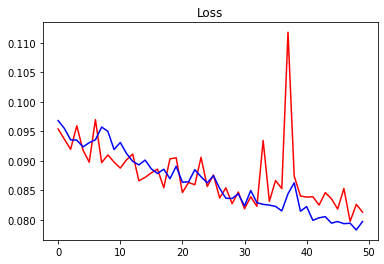

In [136]:
# Fit model step 1
#model = load_model('keras_unet-0.h5',custom_objects=  {'dice_loss_new':dice_loss_new, 'dice_coef': dice_coef,  'iou_core': iou_core, 'MeanIoU':tf.keras.metrics.MeanIoU(num_classes=2, name = 'MeanIoU') }) #Unknown metric function: dice_coef
model.load_weights('keras_unet-0.h5')
K.set_value(model.optimizer.lr, LR/2)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='keras_unet-1.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True)

history = model.fit(X_train, Y_train, 
                    validation_split=validation_split, 
                    batch_size=BATCH_SIZE, 
                    epochs=50,
                    callbacks=[ model_checkpoint_callback],#earlyStopping_callback
                    verbose=2,)
plot_loss_history(history)

Epoch 1/50
19/19 - 3s - loss: 0.0773 - dice_coef: 0.9226 - MeanIoU: 0.8973 - val_loss: 0.0810 - val_dice_coef: 0.9245 - val_MeanIoU: 0.8918

Epoch 00001: val_loss improved from inf to 0.08105, saving model to keras_unet-2.h5
Epoch 2/50
19/19 - 3s - loss: 0.0756 - dice_coef: 0.9246 - MeanIoU: 0.8985 - val_loss: 0.0811 - val_dice_coef: 0.9252 - val_MeanIoU: 0.8960

Epoch 00002: val_loss did not improve from 0.08105
Epoch 3/50
19/19 - 3s - loss: 0.0763 - dice_coef: 0.9238 - MeanIoU: 0.8989 - val_loss: 0.0813 - val_dice_coef: 0.9250 - val_MeanIoU: 0.8944

Epoch 00003: val_loss did not improve from 0.08105
Epoch 4/50
19/19 - 3s - loss: 0.0765 - dice_coef: 0.9233 - MeanIoU: 0.8977 - val_loss: 0.0798 - val_dice_coef: 0.9261 - val_MeanIoU: 0.8966

Epoch 00004: val_loss improved from 0.08105 to 0.07984, saving model to keras_unet-2.h5
Epoch 5/50
19/19 - 3s - loss: 0.0761 - dice_coef: 0.9236 - MeanIoU: 0.8993 - val_loss: 0.0827 - val_dice_coef: 0.9240 - val_MeanIoU: 0.8955

Epoch 00005: val_loss

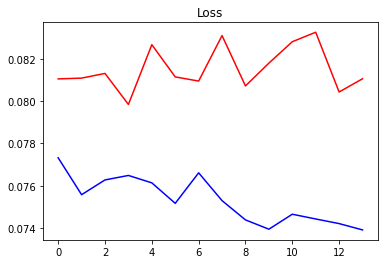

In [137]:
# Fit model step 2 

model.load_weights('keras_unet-1.h5') 
K.set_value(model.optimizer.lr, LR/5)#
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='keras_unet-2.h5',
    save_weights_only=False,
    monitor='val_loss',#'val_MeanIoU',
    mode='min',#'max',
    verbose=1,
    save_best_only=True)
earlyStopping_callback = EarlyStopping(patience=10, verbose=1)
history = model.fit(X_train, Y_train, 
                    validation_split=validation_split, 
                    batch_size=BATCH_SIZE, 
                    epochs=50,
                    callbacks=[earlyStopping_callback, model_checkpoint_callback],
                    verbose=2,)
plot_loss_history(history)

In [ ]:
#model.save('keras_unet.h5')

# 3. Make predictions

In [33]:
#FIN_MODEL = 'keras_unet-2.h5'
FIN_MODEL = '../input/stepfin/keras_unet-2.h5'

In [34]:
# Use model to predict train labels
model = load_model(FIN_MODEL,custom_objects=  {'dice_loss_new':dice_loss_new, 'dice_coef': dice_coef,   'MeanIoU':tf.keras.metrics.MeanIoU(num_classes=2, name = 'MeanIoU') }) #Unknown metric function: dice_coef
Y_predict = model.predict(X_train, verbose=1)
Y_predict.shape

21/21 [==============================] - 66s 3s/step


(670, 256, 256, 1)

In [40]:
# Threshold predictions
#Y_predict_t = (Y_predict > 0.9).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)

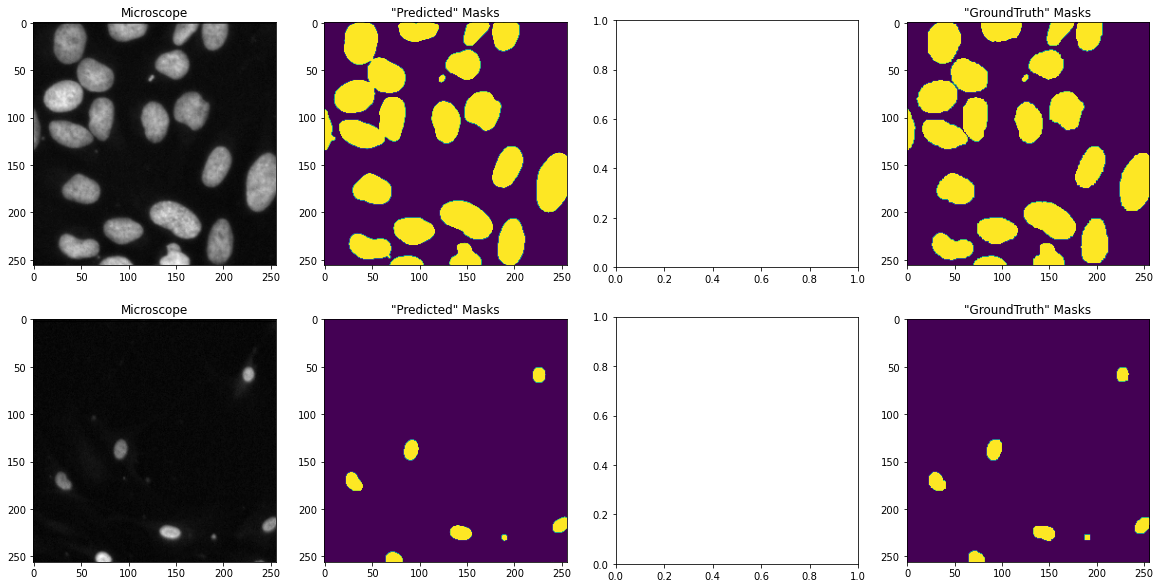

In [45]:
# Check predict data
f, axarr = plt.subplots(2,4)
f.set_size_inches(20,10)
ix = random.randint(0, len(train_ids[1]))
axarr[0,0].imshow(X_train[ix])
axarr[0,0].set_title('Microscope')

axarr[0,1].imshow(np.squeeze(Y_predict[ix]))
axarr[0,1].set_title('"Predicted" Masks')

# axarr[0,2].imshow(np.squeeze(Y_predict_t[ix]))
# axarr[0,2].set_title('"Predicted Threshold" Masks')

axarr[0,3].imshow(np.squeeze(Y_train[ix]))
axarr[0,3].set_title('"GroundTruth" Masks')

ix = random.randint(0, len(train_ids[1]))
axarr[1,0].imshow(X_train[ix])
axarr[1,0].set_title('Microscope')

axarr[1,1].imshow(np.squeeze(Y_predict[ix]))
axarr[1,1].set_title('"Predicted" Masks')

# axarr[1,2].imshow(np.squeeze(Y_predict_t[ix]))
# axarr[1,2].set_title('"Predicted Threshold" Masks')

axarr[1,3].imshow(np.squeeze(Y_train[ix]))
axarr[1,3].set_title('"GroundTruth" Masks')

plt.show()

Смотриться хорошо

In [40]:
# # 4. Encode
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)
        
        
def fin(Y_hat, cutoff=0.5, isTTA=False):
   # Upsample Y_hat back to the original X_test size (height and width)
    Y_hat_upsampled = []
    for i, test_id in enumerate(os.listdir(TEST_PATH)):  #loop through test_ids in the test_path
        img = skimage.io.imread('{0}/{1}/images/{1}.png'.format(TEST_PATH, test_id))  #read original test image directly from path
        img_upscaled = skimage.transform.resize(Y_hat[i], (img.shape[0], img.shape[1]), mode='constant', preserve_range=True)  #upscale Y_hat image according to original test image
        Y_hat_upsampled.append(img_upscaled)   #append upscaled image to Y_hat_upsampled
    print(len(Y_hat_upsampled))
    
    # Apply Run-Length Encoding on our Y_hat_upscaled
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(os.listdir(TEST_PATH)):
        rle = list(prob_to_rles(Y_hat_upsampled[n], cutoff=cutoff))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    print(len(new_test_ids))  #note that for each test_image, we can have multiple entries of encoded pixels

    # Create submission DataFrame
    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    if isTTA:
        sub.to_csv('submissionTTA.csv', index=False)
    else:
        sub.to_csv('submission.csv', index=False)

    print(sub.head())
    print(len(sub))

    print('---------- DONE ---------')    
    

In [38]:
# Get test data
X_test = get_X_data(TEST_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))

# Use model to predict test labels
Y_hat = model.predict(X_test, verbose=1)

Y_hat_noTTA = Y_hat.copy()

Y_hat.shape

3/3 [==============================] - 6s 2s/step


(65, 256, 256, 1)

In [43]:
#Y_hat1 = (Y_hat[:,:,0] > 0.5).astype(np.uint8)

(256, 256, 1)


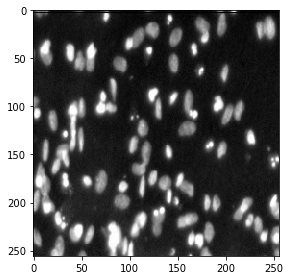

(256, 256)


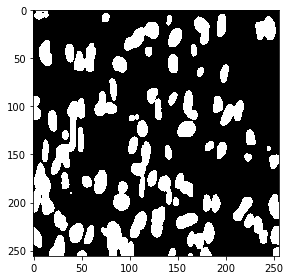

65
2171
                                             ImageId  \
0  fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...   
1  fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...   
2  fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...   
3  fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...   
4  fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...   

                                       EncodedPixels  
0  19457 1 19460 3 19713 7 19969 8 20225 8 20481 ...  
1                            53761 1 54017 1 54273 1  
2  15109 3 15365 4 15620 6 15876 6 16132 7 16388 ...  
3  23048 8 23302 11 23557 12 23813 13 24068 14 24...  
4  46341 5 46596 7 46852 8 47108 8 47364 8 47620 ...  
2171
---------- DONE ---------


array([[False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [46]:
# Gray->BW
idx = random.randint(0, len(test_ids[1]))
print(Y_hat[idx].shape)
skimage.io.imshow(X_test[idx])
plt.show()
thresh = skimage.filters.threshold_otsu(Y_hat[:,:,:,0]*255)
Y_hat_1 = Y_hat[:,:,:,0]*255 > thresh
print(Y_hat_1[idx].shape)
#img = Y_hat[idx][:,:,0]*255 > 0.5
img = Y_hat_1[idx]#[:,0]
skimage.io.imshow(img)
plt.show()
fin(Y_hat_1)
img

(256, 256, 3)


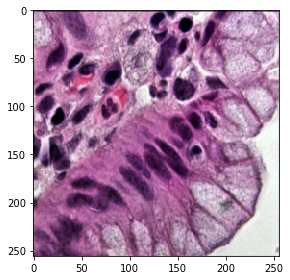

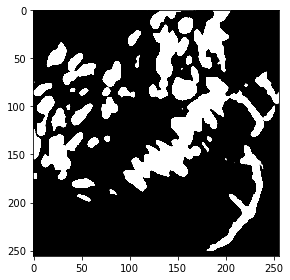

In [47]:
idx = random.randint(0, len(test_ids[1]))
print(X_test[idx].shape)
skimage.io.imshow(X_test[idx])
plt.show()

skimage.io.imshow(Y_hat[idx][:,:,0])
plt.show()

## TTA

In [93]:
class TTA_ModelWrapper():
    """A simple TTA wrapper for keras computer vision models.
    Args:
        model (keras model): A fitted keras model with a predict method.
    """

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        """Wraps the predict method of the provided model.
        Augments the testdata with horizontal and vertical flips and
        averages the results.
        Args:
            X (numpy array of dim 4): The data to get predictions for.
        """

        pred = []
        for x_i in X: #z=Y_hat_noTTA[0:5][ :, :]
            p0 = self.model.predict(self._expand(x_i[:, :]))
            p1 = self.model.predict(self._expand(np.fliplr(x_i[:, :])))
            p2 = self.model.predict(self._expand(np.flipud(x_i[:, :])))
            p3 = self.model.predict(self._expand(np.fliplr(np.flipud(x_i[:, :]))))
#             p = (p0 +
#                  self._expand(np.fliplr(p1[0][:, :])) +
#                  self._expand(np.flipud(p2[0][:, :])) +
#                  self._expand(np.fliplr(np.flipud(p3[0][:, :])))
#                  ) / 4
            
            p = (p0[0] +
                 np.fliplr(p1[0]) +
                 np.flipud(p2[0]) +
                 np.flipud(p3[0])
                 ) / 4
            pred.append(p)
        return np.array(pred)

    def _expand(self, x):
        #return x
        z = np.expand_dims(x, axis=0) # np.expand_dims(np.expand_dims(x, axis=0), axis=3)
       # print(z.shape)
        return z

In [97]:
#model = load_model(FIN_MODEL,custom_objects=  {'dice_loss_new':dice_loss_new, 'dice_coef': dice_coef,   'MeanIoU':tf.keras.metrics.MeanIoU(num_classes=2, name = 'MeanIoU') }) #Unknown metric function: dice_coef
tta_model = TTA_ModelWrapper(model)

Y_hat_TTA = tta_model.predict(X_test)
Y_hat_TTA.shape

(65, 256, 256, 1)

# # 4. Encode and Submit

In [98]:
fin(Y_hat_TTA, cutoff=0.5, isTTA=True )

65
2149
                                             ImageId  \
0  fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...   
1  fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...   
2  fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...   
3  fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...   
4  fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...   

                                       EncodedPixels  
0    19713 1 19716 3 19969 6 20225 6 20481 5 20737 2  
1  15365 3 15621 4 15876 6 16132 6 16388 6 16644 ...  
2  23303 9 23557 12 23813 12 24068 13 24324 13 24...  
3  46342 3 46596 6 46852 7 47108 7 47364 7 47620 ...  
4  51205 3 51460 4 51716 5 51972 5 52228 5 52484 ...  
2149
---------- DONE ---------


In [99]:
###############
fin(Y_hat)

65
2172
                                             ImageId  \
0  fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...   
1  fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...   
2  fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...   
3  fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...   
4  fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...   

                                       EncodedPixels  
0  19457 1 19460 3 19713 7 19969 8 20225 8 20481 ...  
1                            53761 1 54017 1 54273 1  
2  15109 3 15365 4 15620 6 15876 6 16132 7 16388 ...  
3  23048 8 23302 11 23557 12 23813 13 24068 14 24...  
4  46341 5 46596 7 46852 8 47108 8 47364 8 47620 ...  
2172
---------- DONE ---------


In [ ]:
# Clean Folder
# import shutil
# shutil.rmtree('train')
# shutil.rmtree('test')

Готово!

## Что можно сделать, чтоб улучшить результат:
* Подобрать LR, optimizer, loss
* Добавить свою метрику (для сегментации loss не лучшая метрика) и callbacks по ней
* Поставить и подобрать Threshold для predictions
* Добавить аугментацию
* Поиграться с архитектурой
* Подобрать другие переменные (размер картинки, батч и тп)
* Добавить политику обучения
* Добавить TTA
* Найти и обучиться на других внешних данных
* Построить ансамбль из разных архитектур

Удачи в соревновании!